# Hidden Markov Models for event segmentation

Hidden Markov Models (HMM) allow us to temporally cluster brain activity into discrete events, and to identify event correspondences between datasets. This tutorial describes how to fit HMMs to a narrative dataset, how to statistically verify the identified event boundaries, how to align multiple datasets, and how to apply HMMs to connectivity data. A full description of the model is given in [the Neuron paper](http://www.dpmlab.org/Neuron17.pdf).

In [1]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition

First, download whole-brain data from 17 subjects watching the first hour of [A Study in Pink](https://en.wikipedia.org/wiki/A_Study_in_Pink). Voxels with low intersubject correlation (that were not consisently activated across subjects) were removed, and then the data was downsampled into 141 large regions (from a [resting-state atlas](http://www.dpmlab.org/peerj-784.pdf)). After putting this .h5 file into the same directory as this notebook, we can load in the data. In addition to the BOLD fMRI data, we have the coordinates of each region, as well as human-labeled boundaries for event boundaries.

In [ ]:
!wget https://ndownloader.figshare.com/files/9017983 -O sherlock.h5

In [2]:
D = dd.io.load('sherlock.h5')
BOLD = D['BOLD']
coords = D['coords']
human_bounds = D['human_bounds']
nR = BOLD.shape[0]
nTR = BOLD.shape[1]
nSubj = BOLD.shape[2]

## Fitting HMM to activity patterns

The goal of the HMM is to identify chunks of time during which activity patterns remain relatively constant. To see if this is a reasonable model for our dataset, we can plot a timepoint-timepoint correlation matrix, showing the similarity between every pair of timepoints in our dataset (averaged over subjects).

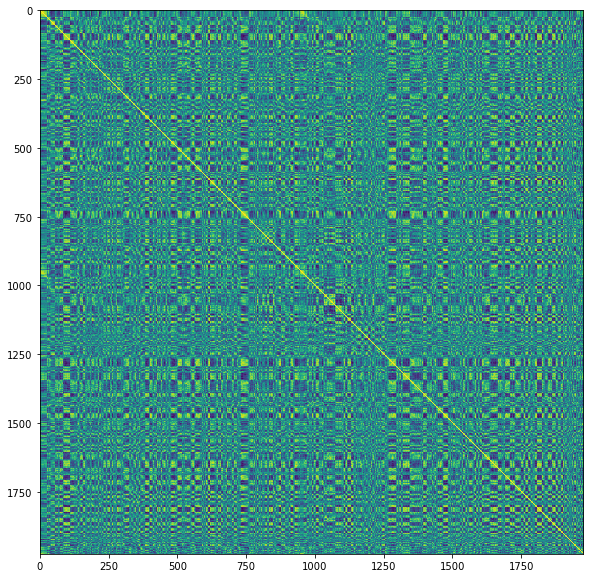

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(np.corrcoef(BOLD.mean(2).T))

Although there is a lot of potentially interesting structure here, the main thing to notice is that there are little blocks of high correlation along the diagonal. These blocks are about 30 TRs long = 45 seconds, suggesting that they are related to relatively slowly-changing features of the movie (i.e. semantically-meaningful scenes) rather than low-level properties e.g. dependent on the current camera angle.

To fit the HMM to the group-averaged data, we simply pass it to the event segmentation module in brainiak.

In [4]:
ev = brainiak.eventseg.event.EventSegment(70)
ev.fit(BOLD.mean(2).T)

EventSegment(n_events=70, n_iter=500,
       step_var=<function EventSegment._default_var_schedule at 0x7fdcfe349b70>)

One way of visualizing the fit is to mark on the timepoint correlation matrix where the model thinks the borders of the events are. The (soft) event segmentation is in ev.segments\_\[0\], so we can convert this to hard bounds by taking the argmax.

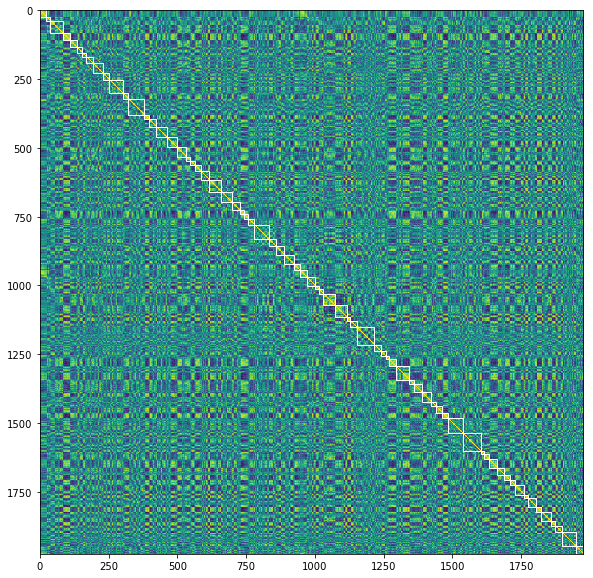

In [5]:
bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
plt.figure(figsize=(10,10))
plt.imshow(np.corrcoef(BOLD.mean(2).T))
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=1,edgecolor='w',facecolor='none')
    ax.add_patch(rect)

Another output of the event segmentation fit is the estimated activity pattern for each event. Since we are using whole-brain atlas data, this corresponds to a pattern of actvity across the whole brain. We can visualize the first few of these event patterns as an example - in these plots, the back of the brain is at the left, and the front is at the right.

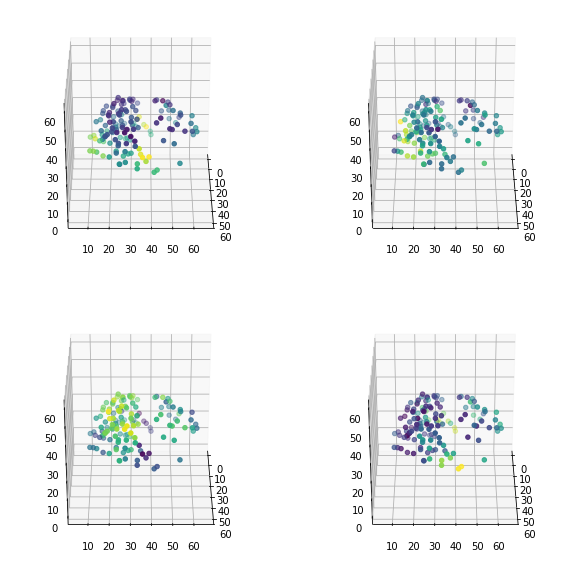

In [6]:
fig = plt.figure(figsize=(10,10))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=ev.event_pat_[:,i])
    ax.auto_scale_xyz([0,60],[5,65],[0,60])
    ax.view_init(30,0)

## Statistical testing for model boundaries

One way to test whether the model-identified boundaries are consistent across subjects is to fit the model on all but one subject and try to predict something about the held-out subject. There are multiple approaches for doing this (see the [Neuron supplementary material](http://www.dpmlab.org/Neuron17.pdf) for some alternatives), but the simplest is to check whether the model boundaries predict pattern changes in the held-out subject. We therefore measure whether activity patterns 5 TRs apart show a drop in correlation when they are on opposite sides of an event boundary.

For comparison, we generate permuted versions of the model boundaries, in which the distribution of event lengths (the distances between the boundaries) is held constant but the order of the event lengths is shuffled. This should should have a within vs. across boundary difference of zero on average, but the variance of these null boundaries lets us know that we are well above chance differences.

In [7]:
w = 5  # window size
nPerm = 1000
within_across = np.zeros((nSubj, nPerm+1))
for left_out in range(nSubj):
    # Fit to all but one subject
    ev = brainiak.eventseg.event.EventSegment(70)
    ev.fit(BOLD[:,:,np.arange(nSubj) != left_out].mean(2).T)
    events = np.argmax(ev.segments_[0], axis=1)

    # Compute correlations separated by w in time
    corrs = np.zeros(nTR-w)
    for t in range(nTR-w):
        corrs[t] = pearsonr(BOLD[:,t,left_out],BOLD[:,t+w,left_out])[0]
    _, event_lengths = np.unique(events, return_counts=True)

    # Compute within vs across boundary correlations, for real and permuted bounds
    np.random.seed(0)
    for p in range(nPerm+1):
        within = corrs[events[:-w] == events[w:]].mean()
        across = corrs[events[:-w] != events[w:]].mean()
        within_across[left_out, p] = within - across

        perm_lengths = np.random.permutation(event_lengths)
        events = np.zeros(nTR, dtype=np.int)
        events[np.cumsum(perm_lengths[:-1])] = 1
        events = np.cumsum(events)
    print('Subj ' + str(left_out+1) + ': WvsA = ' + str(within_across[left_out,0]))

Subj 1: WvsA = 0.164989431658
Subj 2: WvsA = 0.177369188205
Subj 3: WvsA = 0.208460841171
Subj 4: WvsA = 0.214482490154
Subj 5: WvsA = 0.195481255048
Subj 6: WvsA = 0.197036459013
Subj 7: WvsA = 0.172807390315
Subj 8: WvsA = 0.223990387603
Subj 9: WvsA = 0.159965587744
Subj 10: WvsA = 0.15483698521
Subj 11: WvsA = 0.23261309099
Subj 12: WvsA = 0.221226839507
Subj 13: WvsA = 0.249240646473
Subj 14: WvsA = 0.0882793360337
Subj 15: WvsA = 0.137179304274
Subj 16: WvsA = 0.208124479738
Subj 17: WvsA = 0.210025592828


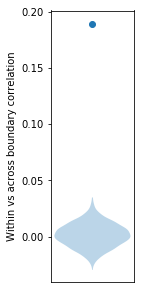

In [8]:
plt.figure(figsize=(1.5,5))
plt.violinplot(within_across[:,1:].mean(0), showextrema=False)
plt.scatter(1, within_across[:,0].mean(0))
plt.gca().xaxis.set_visible(False)
plt.ylabel('Within vs across boundary correlation')

## Comparing model boundaries to human-labeled boundaries

We can also compare the event bounds from the model to human-labeled event boundaries. Since there is some ambiguity in both the stimulus and the model about exactly which timepoint the transition occurs at, we will count two boundaries as being a "match" if they are within 3 TRs (4.5 seconds) of each other.

To determine whether the match is statistically significant, we generate permuted versions of the model boundaries as above. This gives as a null model for comparison (i.e. how often will a human and model bound be within 3 TRs of each other by chance?).

p = 1.95491295074e-05


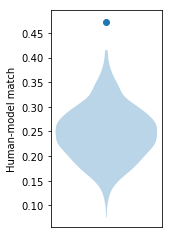

In [9]:
event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
np.random.seed(0)
nPerm = 1000
match = np.zeros(nPerm+1)
perm_bounds = bounds
for p in range(nPerm+1):
    for hb in human_bounds:
        if np.any(np.abs(perm_bounds - hb) <= 3):
            match[p] += 1
    match[p] /= len(human_bounds)
    
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))

## Aligning movie and recall data

A simple model of free recall is that a subject will revisit the same sequence of events experienced during perception, but the lengths of the events will not be identical between perception and recall. We can fit this model by separately estimating event boundaries in movie and recall data, while constraining the event patterns to be the same across the two datasets.

We will now download fMRI data from the angular gyrus, consisting of (group average) movie-watching data, and free recall data for a single subject. We also have a human-labeled correspondence between the movie and the recall (based on the transcript of the verbal recall). The full dataset for all 17 subjects is [available here](https://ndownloader.figshare.com/files/9055471).

In [ ]:
!wget https://ndownloader.figshare.com/files/9055612 -O AG_movie_1recall.h5

In [11]:
D = dd.io.load('AG_movie_1recall.h5')
movie = D['movie']
nVox = movie.shape[0]
movie_T = movie.shape[1]
recall = D['recall']
movie_labels = D['movie_labels']
recall_labels = D['recall_labels']

We use the same fit function as for a single dataset, but now we pass in both the movie and recall datasets in a list.

In [12]:
ev = brainiak.eventseg.event.EventSegment(25)
ev.fit([movie.T, recall.T])

EventSegment(n_events=25, n_iter=500,
       step_var=<function EventSegment._default_var_schedule at 0x7fdcfe349b70>)

This divides the movie and recall into 25 *corresponding* events, with the same 25 event patterns. We can plot the probability that each timepoint is in a particular event.

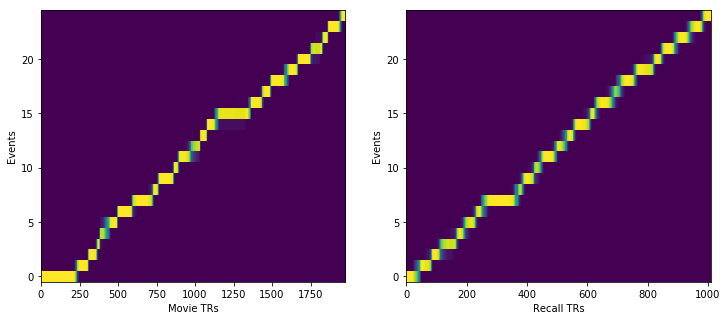

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(ev.segments_[0].T,aspect='auto',origin='lower')
plt.xlabel('Movie TRs')
plt.ylabel('Events')

plt.subplot(1,2,2)
plt.imshow(ev.segments_[1].T,aspect='auto',origin='lower')
plt.xlabel('Recall TRs')
plt.ylabel('Events')

To get the temporal correspondence between the movie and the recall, we need to find the probability that a movie TR and a recall TR are in the same event (regardless of which event it is). This is
$$
\sum_k p(T_M == k) \cdot p(T_R == k)
$$
which we can compute by a simple matrix multiplication.

For comparison, we also plot the human-labeled correspondence as white boxes.

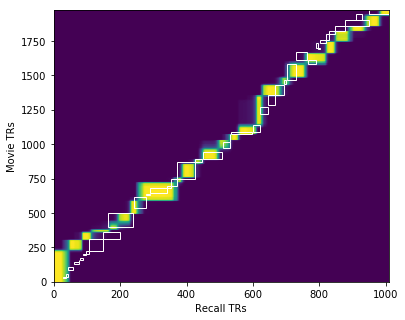

In [14]:
plt.figure(figsize=(6,5))
plt.imshow(np.dot(ev.segments_[1], ev.segments_[0].T).T,aspect='auto',origin='lower')
ax = plt.gca()
for i in np.unique(movie_labels[movie_labels>0]):
    if not np.any(recall_labels==i):
        continue
    movie_start = np.where(movie_labels==i)[0][0]
    movie_end = np.where(movie_labels==i)[0][-1]
    recall_start = np.where(recall_labels==i)[0][0]
    recall_end = np.where(recall_labels==i)[0][-1]

    rect = patches.Rectangle((recall_start-0.5, movie_start-0.5), recall_end - recall_start + 1, movie_end - movie_start + 1,linewidth=1,edgecolor='w',facecolor='none')
    ax.add_patch(rect)
plt.xlabel('Recall TRs')
plt.ylabel('Movie TRs')

## Tracking network dynamics

In all analyses so far, we have defined a brain state to be a first-order pattern of activity (in a region or across the cortex). Alternatively we could define a brain state based on the second-order correlations between regions, to capture how interactions between regions are changing over time.

Rather than using the standard approach of simply taking pairwise correlation between timecourses (in a single or group average), we can focus specifically on the stimulus-driven correlations by computing the ISFC (intersubject functional correlation), in which we take correlations between timecourse across subjects. We switch back to the 141-region atlas data for this section.

The correlation between two z-scored timecourses $x$ and $y$ is simply the average pairwise product
$$
\frac{1}{T} \sum_t x_t y_t
$$
Since we will want to look at how the ISFC changes over time, we separately compute each of these pairwise products. We can then recover the correlations by taking the average over all timepoints, and can also look at more fine-grained periods by taking averages over shorter time periods.

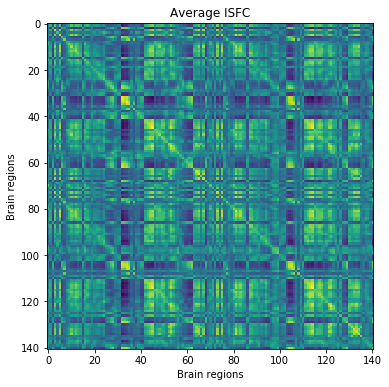

In [15]:
ISFC = np.zeros((nR, nR, nTR))
for s in range(nSubj):
    group = zscore(BOLD[:,:,np.arange(nSubj) != s].mean(2), axis=1)
    subj = zscore(BOLD[:,:,s], axis=1)
    for t in range(nTR):
        ISFC[:,:,t] += np.outer(group[:,t], subj[:,t])/nSubj

plt.figure(figsize=(6,6))
plt.imshow(ISFC.mean(2))
plt.xlabel('Brain regions')
plt.ylabel('Brain regions')
plt.title('Average ISFC')

Next we need to decide on a moving window in which to estimate dynamic ISFC. To use a Gaussian window with standard deviation of 50 TRs, we can convolve the Gaussian weighting with our pairwise products.

We can then plot a matrix of how similar the ISFC is at different timepoints.

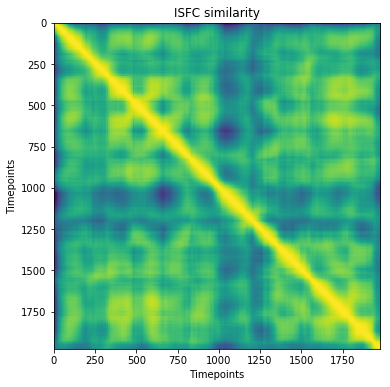

In [16]:
ISFC = ISFC.reshape((nR*nR, nTR))
sig = 50
win = gaussian(3*sig, sig)[np.newaxis, :]
ISFC_smooth = convolve(ISFC, win/win.sum(), mode='same')

plt.figure(figsize=(6,6))
plt.imshow(np.corrcoef(ISFC_smooth.T))
plt.xlabel('Timepoints')
plt.ylabel('Timepoints')
plt.title('ISFC similarity')

We could try to plug this ISFC directly in the HMM, but it would be extremely slow, since each timepoint has $141^2$=19881 connectivity features. Instead we can reduce the dimensionality without losing information about which timepoints are similar to each other. We do this by computing the SVD of the (z-scored) data matrix, and retaining only the top 50 modes (with largest eigenvalues). This is equivalent to computing PCA on the square of the data matrix.

Plotting the similarity matrix for the reduced-dimension data, we find that we made the data 400x smaller without losing any structure!

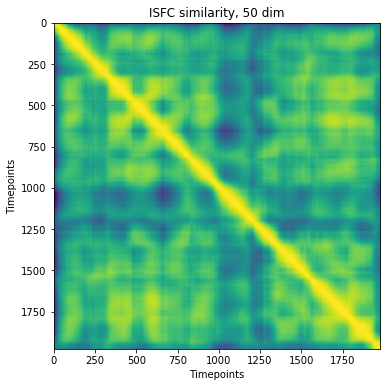

In [17]:
ISFC_z = zscore(ISFC_smooth, axis=0, ddof=1)
U, S, V = np.linalg.svd(ISFC_z.T, full_matrices=False)
ISFC_pca = np.dot(U[:,:50],np.diag(S[:50])).T

plt.figure(figsize=(6,6))
plt.imshow(np.corrcoef(ISFC_pca.T))
plt.xlabel('Timepoints')
plt.ylabel('Timepoints')
plt.title('ISFC similarity, 50 dim')

We can then plug the data into the HMM to identify temporal clusters. Since we can only estimate dynamic ISFC at slower timescales, this division will be coarser than that for first-order activity.

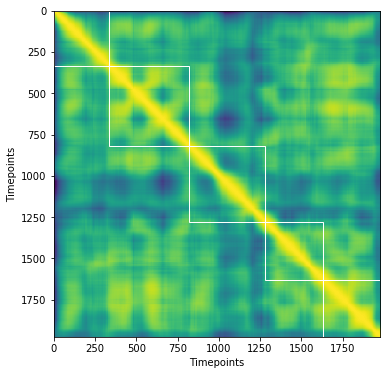

In [18]:
ev = brainiak.eventseg.event.EventSegment(5)
ev.fit(ISFC_pca.T)

plt.figure(figsize=(6,6))
bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
plt.imshow(np.corrcoef(ISFC_pca.T))
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=1,edgecolor='w',facecolor='none')
    ax.add_patch(rect)
plt.xlabel('Timepoints')
plt.ylabel('Timepoints')

We can visualize what each of these 5 ISFC periods looks like in the original space 141x141, by taking a weighted average of the original ISFC matrices for each of the event segments. Note that we can easily take weighted sums over a multidimensional array using [Einstein summation](http://ajcr.net/Basic-guide-to-einsum/).

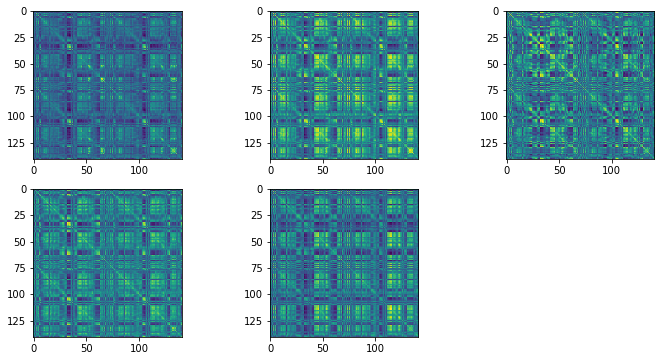

In [19]:
weights = ev.segments_[0] / ev.segments_[0].sum(0)[np.newaxis, :]
event_conn = np.einsum("ijt,tk->ijk",ISFC.reshape((nR,nR,nTR)),weights)
fig = plt.figure(figsize=(12,6))
for i in range(5):
    fig.add_subplot(2,3,i+1)
    plt.imshow(event_conn[:,:,i])